# Locally Linear Embedding (40 P)

In this assignment we will look at locally linear embedding and experiment with it on artificially generated datasets. The effects of neighbourhood size and noise on result quality will be analyzed.

Information about the algorithm, publications and demos can be found at http://www.cs.nyu.edu/~roweis/lle/

A guide for plotting can be found here: http://nbviewer.ipython.org/github/jrjohansson/scientific-python-lectures/blob/master/Lecture-4-Matplotlib.ipynb

We first start by importing some basic python libraries for numerical computation and plotting.

In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D
import scipy.spatial, scipy.linalg

The file `utils.py` contains several methods to generate pseudo-random three-dimensional datasets. They all have a low-dimensional manifold structure. The following code plots each dataset with default generation parameters (`N=1000` examples, and Gaussian noise of scale `0.25`).

spiral


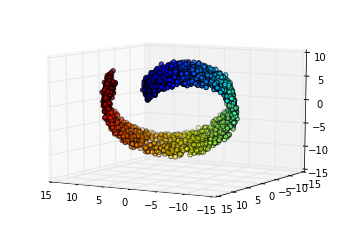

roll


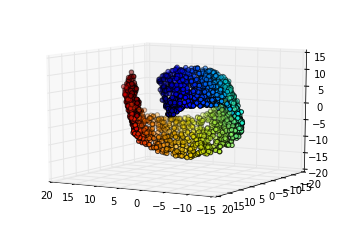

wave


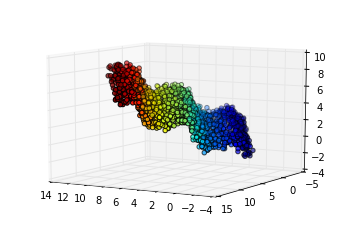

fold


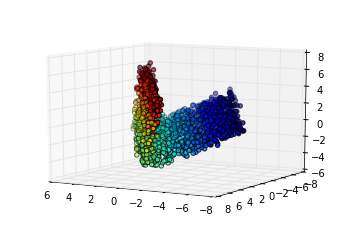

In [2]:
import utils
%matplotlib inline

for dataset in [utils.spiral,utils.roll,utils.wave,utils.fold]:
    print(dataset.__name__)
    data,color = dataset(N=2000,noise=0.25)
    plt.figure()
    ax = plt.gca(projection='3d')
    ax.view_init(elev=10., azim=120)
    ax.scatter(data[:,0],data[:,1],data[:,2],c=color)
    plt.show()

## Implementing LLE (20 P)

**Implement a function `LLE(data,k)`**. The function takes as input the high-dimensinonal data the number of neighbors `k` used for reconstruction in the LLE algorithm. It returns the resulting 2D embedding (a two-dimensional array of size `Nx2`). A backbone of the implementation is given below. The implementation of LLE is described in the paper "An Introduction to LLE" linked from ISIS.

*Reminder: During computation, you need to solve the problem Cw=**1**, where **1** is a column vector (1,1,...,1). In case k>d i.e. the size of the neighbourhood is larger than the number of dimensions of the space we're mapping to, it is necessary to regularize the matrix C. You can do this by adding positive terms on the diagonal. A good starting point is 0.05.*

In [3]:
def distmat(M, X):
    ''' 
 
            
    Usage:
        D = distmat( M, X )
    Parameters:
        M: (d x k) array of column vectors
        X: (d x n) array of column vectors
    Returns:
        D: (k x n) array of distances between the vectors in M and X
    
    Instructions:
        see exercise sheet!
        *
        Hint: use matrix multiplications (dot-product) to avoid for-loops!
        Hint: Though this can be done as a one-liner, maybe it helps to specify 
                M2, MX and X2 explicitly
        Hint: if you use sum(), consider the keepdims=True option
        Hint: think about the dimensions and use broadcasting!
    '''
    # your code here
    M2 = np.sum(M**2,0,keepdims=True)
    X2 = np.sum(X**2,0,keepdims=True)
    MX = M.T.dot(X)
    D2 = M2.T - 2*MX + X2
    D2[D2<0] = 0
    return np.sqrt(D2)

In [4]:
# Backbone implementation

def LLE(data,k):
    ''' 
        The function takes as input the high-dimensinonal data the number of neighbors k 
        used for reconstruction in the LLE algorithm. 
        It returns the resulting 2D embedding (a two-dimensional array of size Nx2).
    Usage:
        D = distmat( M, X )
    Parameters:
        data: (N x 3) array of column vectors
        k: number of considered neighbours 
    Returns:
        LLE: (N x 2) 
    
    '''
    N = len(data)
    W = np.zeros([N,N]) # matrix for storing reconstruction weights
    M = np.zeros([N,N]) # matrix M of which eigenvectors are computed
    E = np.zeros([N,2]) # eigenvectors of M forming the embedding
    
    v = 0.05
    
    # little helper NxN matrix where x_ij = distance from point i to j
    D = distmat(data.T, data.T)
    # distance of a point to itself is not a neigbor
    # therefore we just set it to a very high value that it will drop out when sorted
    np.fill_diagonal(D, np.infty)
    # Iterate over all data points to find their associated reconstruction weight
    for i in range(N):
        
        # 1. find nearest neighbors of data[i]
        knnIdx_i = np.argsort(D[i])[0:k]
        KNN_i = data[knnIdx_i]
        
        # 2. compute local covariance (with diagonal regularization), and invert it
        temp = ((np.ones((k,1)).dot((data[i].reshape(1,3)))-KNN_i))
        c_i = temp.dot(temp.T)
        # is 
        # 3. compute reconstruction weights and store them in the row of the matrix W
        w = (np.linalg.inv(c_i + v*np.eye(k))).dot(np.ones(k))
        w = w/((w.T).dot(np.ones(k)))
        
        W[i,knnIdx_i] = w
        

    # 4. Compute the matrix M from W and compute the desired eigenvectors E of M
    
    M = ((np.eye(N)-W).T).dot(np.eye(N)-W)
    a,b = np.linalg.eig(M)
    e = np.argsort(a)[1:3]
    print a.shape
    print b.shape
    E = b[:,e]
    return E

### TODO: Replace with your own implementation of LLE
#import solutions
#from solutions import LLE
###

**Test your implementation by running the code below.** It plots the original data (projected on the first two dimensions), and below, the two-dimensional embedding. A correct implementation produces a two-dimensional dataset where the manifold is unfolded, and where nearby points in the embedding are also neighbors in the manifold, in particular, neighboring points in the plot should have similar color.

(1000,)
(1000, 1000)
(1000, 2)


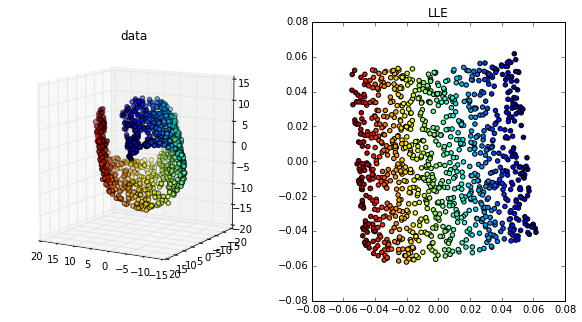

In [5]:
import utils
%matplotlib inline
data,color = utils.roll()
embedding = LLE(data,k=20)
print embedding.shape
fig = plt.figure(figsize=(10,5))

ax = fig.add_subplot(1,2,1,projection='3d')
ax.view_init(elev=10., azim=120)
ax.scatter(data[:,0],data[:,1],data[:,2],c=color)
ax.set_title('data')

ax = fig.add_subplot(1,2,2)
ax.scatter(embedding[:,0],embedding[:,1],c=color)
ax.set_title('LLE')

## Experiments (20 P)

The function `compare(embed,dataset)`takes as input an embedding function and a dataset and plots the resulting embeddings for various choices of the parameter `k`, in particular, `k=5,20,80`.

In [ ]:
def compare(embed, dataset):
    cols = 4
    
    fig = plt.figure(figsize=(3*cols, 3))
    
    # Plot the data
    data, color = dataset()
    ax = fig.add_subplot(1, cols, 1,projection='3d')
    ax.view_init(elev=10., azim=120)
    ax.scatter(data[:,0],data[:,1],data[:,2],c=color)
    
    ax.set_title('data')
    ax.set_xticks([], [])
    ax.set_yticks([], [])
    ax.set_zticks([], [])

    # Plot embeddings with various parameters K
    for i, k in enumerate([5,20,80]):
        ax = fig.add_subplot(1, cols, 2+i)

        z = embed(data,k=k)

        ax.scatter(z[:,0], z[:,1], c=color)
        ax.set_title('LLE, k=%d'%k)
        ax.set_xticks([], [])
        ax.set_yticks([], [])
    plt.tight_layout()
    plt.show()

### Datasets and optimal parameter `k`

The code below tests the LLE embedding algorithm on each dataset: spiral, roll, wave, and fold. **Explain** what is a good parameter `k` of the LLE algorithm, and how this parameter relates to the various properties of the dataset.

**[TODO: WRITE YOUR ANSWER HERE]**

In [ ]:
for dataset in [utils.spiral,utils.roll,utils.wave,utils.fold]:
    print(dataset.__name__)
    compare(LLE,dataset)

spiral
(1000,)
(1000, 1000)
(1000,)

### LLE and the effect of noise

The code below tests LLE on the spiral dataset with three different levels of noise. **Describe** how the noise affects the embedding.

**[TODO: WRITE YOUR ANSWER HERE]**

In [ ]:
for noise in [0.1,0.3,1.0]:
    print('noise=%.3f'%noise)
    dataset = lambda: utils.spiral(noise=noise)
    compare(LLE,dataset)

### Discussion

* When applying LLE to a 200-dimensional dataset which can't be visualized, how would you assess whether the found embedding is good? Discuss how you would do it or argue why it can't be done.

 **[TODO: WRITE YOUR ANSWER HERE]**


* Could utilizing this technique in conjuction with a classifier improve its performance? Which classifiers, if any, would benefit the most?

 **[TODO: WRITE YOUR ANSWER HERE]**